<a href="https://colab.research.google.com/github/Murcha1990/ML_Course_PT/blob/main/Lecture3_Data%26Trees/DGA_improvements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задачи классификации

Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from math import log2

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


### Обнаружение DGA-доменов

Эта задача посвящена выявлению алгоритмически сгенерированных доменов второго уровня (SLD) в доменных именах. Ваша задача — построить модель машинного обучения, способную отличать легитимные домены от SLD, сгенерированных с помощью DGA.

**Цель**

Цель — обнаружение алгоритмически сгенерированных доменов второго уровня (SLD), которые часто используются вредоносным ПО для обхода механизмов обнаружения. У нас есть датасет доменных имен с метками: DGA (1) или легитимный (0). Обратите внимание, что в некоторых примерах предоставляется только SLD без домена верхнего уровня (TLD).

Поскольку ложноположительные срабатывания (когда легитимный домен ошибочно классифицируется как DGA) могут приводить к серьезным проблемам, минимизация ложноположительных ошибок важнее, чем минимизация ложноотрицательных.

In [ ]:
!pip install tqdm

Скачаем тренировочный датасет по ссылке.

In [ ]:
# или скачать файл train.csv с kaggle

!wget -O dga.csv "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/f2Z4w-xHheenKg"

--2026-02-09 13:48:15--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/f2Z4w-xHheenKg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 138.199.175.196
Connecting to getfile.dokpub.com (getfile.dokpub.com)|138.199.175.196|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/1f67bfe7341ffa80d69cb411d5812bc1f14ed2b176ceee68ee380be7b728ba12/698a081c/0F8ZdSEE6bEiq3zgKLsJP05XO4AC9ufyrXMW5UgtacVTptX9sWjOnpcHQpu7iCbA3x-wCfRFjW8x1tXXep-8yA%3D%3D?uid=0&filename=train_dga.csv&disposition=attachment&hash=ES%2BZaDNM863i5u9PjpBnP1sJhtbTnNSlZg%2Btb04JzVMo4tv58hzotGiOIsxkjVRPq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=text%2Fcsv&owner_uid=259847718&fsize=331518539&hid=2e72185b076ef407efbf7bedfed36b5f&media_type=data&tknv=v3 [following]
--2026-02-09 13:48:15--  https://downloader.disk.yandex.ru/disk/1f67bfe7341ffa80d69cb411d5812bc1f14ed2b176ceee68ee380be7b728ba12/698a081c/0F8ZdSEE6bEiq3zgKLsJP05XO4AC9ufyrXMW5

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from math import log2

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Посмотрим на данные

In [ ]:
data = pd.read_csv("dga.csv")

data.head()

,domain,label
0,c4wfahorcxq41ps0g0u,1
1,goievinskycattederifg,1
2,ypqbo2g854e4sb7re8i2e2e,1
3,cmikleasuredehydratorysagp.com,1
4,apodoc.saarland,0


In [ ]:
data.sample(10)

,domain,label
14091683,debate21,0
8343889,quadnfbqqanvbufnvi,1
9274539,rhrwyykczl,1
14385891,xjshmen.com,1
14676856,gbdcpa,0
17562702,aaswssmc,1
13301793,hyzhihe.com,0
248393,tipo-e,0
10884448,jkwwlvbgrgh,1
12373574,1omz50d1jfw6q91ejpdpcg7b0r4,1


Посмотрим на баланс классов

In [ ]:
data['label'].value_counts(normalize=True)

,proportion
label,
0,0.555226
1,0.444774


In [ ]:
len(data)

17719790

In [ ]:
data = data.sample(800_000, random_state=42)

len(data)

800000

### Feature engineering

Самая важная честь - придумать признаки, на которых мы будем решать задачу.

In [ ]:
VOWELS = set("aeiou") # множество гласных букв

def shannon_entropy(s):
    probs = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * log2(p) for p in probs)

def digit_ratio(name):
    length = len(name)
    digits = sum(c.isdigit() for c in name)
    return digits / max(1, length)

def letter_count(name):
    return sum(c.isalpha() for c in name)

def has_digits(name):
    return int(any(c.isdigit() for c in name))

def vowel_ratio(name):
    letters = sum(c.isalpha() for c in name)
    vowels = sum(c in VOWELS for c in name)
    return vowels / max(1, letters)

def extract_features(domain):
    name = domain.split('.')[0]

    length = len(name)                                      # длина
    digits = sum(c.isdigit() for c in name)                 # количество цифр
    has_digits_flag = digits > 0                            # есть ли цифры
    letters = sum(c.isalpha() for c in name)                # количество букв
    entropy = shannon_entropy(name) if length > 0 else 0    # энтропия
    has_dash_flag = "-" in name                             # есть ли дефис
    dash_count = name.count("-")                            # количество дефисов
    digit_ratio_value = digit_ratio(name)                   # доля цифр
    dot_count = domain.count(".")                           # количество точек
    vowel_ratio_value = vowel_ratio(name)                   # доля гласных

    return [
        length,
        digits,
        int(has_digits_flag),
        letters,
        entropy,
        int(has_dash_flag),
        dash_count,
        digit_ratio_value,
        dot_count,
        vowel_ratio_value,
    ]

Разобъем данные на train и test

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
len(train), len(test)

(600000, 200000)

In [ ]:
X_train = np.array([
    extract_features(str(d))
    for d in tqdm(train["domain"], desc="Extracting train features") # прогресс-бар
])

y_train = train["label"].values

X_test = np.array([
    extract_features(str(d))
    for d in tqdm(test["domain"], desc="Extracting test features")
])

y_test = test["label"].values

Extracting test features: 100%|██████████| 200000/200000 [00:02<00:00, 67924.11it/s]


Перед применением модели давайте масштабируем признаки!

In [ ]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression( # используем простую модель логрега
        max_iter=100,
        random_state=0
    )
)

In [ ]:
model.fit(X_train, y_train) # обучаем модель

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

Оценим качество получившейся модели

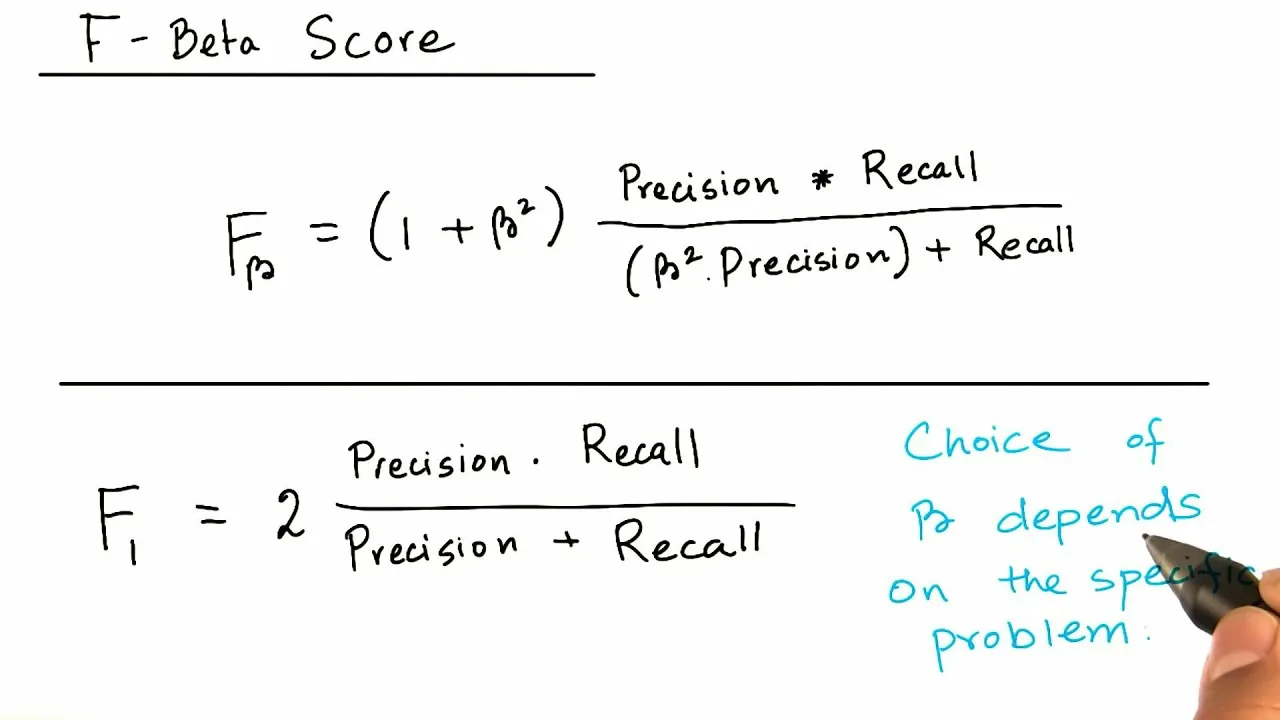

In [ ]:
from sklearn.metrics import fbeta_score

y_test_pred = model.predict(X_test) # предсказываем на валидационной выборке

fbeta = fbeta_score(y_test, y_test_pred, beta=0.5) # вычисляем f_beta скор
print(fbeta)

0.7655874251751622


Давайте посмотрим и на остальные показатели, для этого есть функция classification_report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7899    0.8312    0.8100    110702
           1     0.7762    0.7259    0.7502     89298

    accuracy                         0.7842    200000
   macro avg     0.7830    0.7785    0.7801    200000
weighted avg     0.7838    0.7842    0.7833    200000



classification_report вывел значения **precision**, **recall**, **F1-score** и **support** для каждого класса:

- **0** — нормальные домены  
- **1** — DGA-домены  

Также выводятся:

- **accuracy** — общая доля правильных предсказаний  

- **macro avg** — среднее арифметическое метрик по классам  

- **weighted avg** — среднее метрик, взвешенное по количеству объектов каждого класса  


## Улучшаем решение

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

f2_scorer = make_scorer(fbeta_score, beta=2)

params = {'logisticregression__class_weight' : [None, 'balanced'],
          'logisticregression__C' : [0.5, 1., 2.]}

gs = GridSearchCV(model, params, verbose=3, scoring=f2_scorer)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.5, logisticregression__class_weight=None;, score=0.735 total time=   3.3s
[CV 2/5] END logisticregression__C=0.5, logisticregression__class_weight=None;, score=0.734 total time=   3.3s
[CV 3/5] END logisticregression__C=0.5, logisticregression__class_weight=None;, score=0.733 total time=   3.3s
[CV 4/5] END logisticregression__C=0.5, logisticregression__class_weight=None;, score=0.734 total time=   2.7s
[CV 5/5] END logisticregression__C=0.5, logisticregression__class_weight=None;, score=0.739 total time=   2.6s
[CV 1/5] END logisticregression__C=0.5, logisticregression__class_weight=balanced;, score=0.767 total time=   2.5s
[CV 2/5] END logisticregression__C=0.5, logisticregression__class_weight=balanced;, score=0.768 total time=   3.5s
[CV 3/5] END logisticregression__C=0.5, logisticregression__class_weight=balanced;, score=0.766 total time=   3.3s
[CV 4/5] END logisticregression__C=0.5, 

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=0))]),
             param_grid={'logisticregression__C': [0.5, 1.0, 2.0],
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=3)

In [ ]:
gs.best_score_, gs.best_estimator_, gs.best_params_

(np.float64(0.7679104244570201),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(class_weight='balanced', random_state=0))]),
 {'logisticregression__C': 1.0,
  'logisticregression__class_weight': 'balanced'})

## Улучшаем дальше

In [ ]:
!pip install catboost -q

In [ ]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(n_estimators=100)

In [ ]:
cb.fit(X_train, y_train) # обучаем модель

Learning rate set to 0.5
0:	learn: 0.5398999	total: 188ms	remaining: 18.6s
1:	learn: 0.4809292	total: 361ms	remaining: 17.7s
2:	learn: 0.4491989	total: 524ms	remaining: 17s
3:	learn: 0.4291427	total: 638ms	remaining: 15.3s
4:	learn: 0.4182796	total: 763ms	remaining: 14.5s
5:	learn: 0.4103889	total: 950ms	remaining: 14.9s
6:	learn: 0.4048187	total: 1.13s	remaining: 15.1s
7:	learn: 0.4013649	total: 1.23s	remaining: 14.1s
8:	learn: 0.3978402	total: 1.38s	remaining: 13.9s
9:	learn: 0.3950283	total: 1.53s	remaining: 13.8s
10:	learn: 0.3925870	total: 1.69s	remaining: 13.7s
11:	learn: 0.3907383	total: 1.83s	remaining: 13.5s
12:	learn: 0.3894415	total: 1.98s	remaining: 13.3s
13:	learn: 0.3867095	total: 2.13s	remaining: 13.1s
14:	learn: 0.3857633	total: 2.31s	remaining: 13.1s
15:	learn: 0.3845934	total: 2.47s	remaining: 13s
16:	learn: 0.3839776	total: 2.59s	remaining: 12.7s
17:	learn: 0.3828419	total: 2.69s	remaining: 12.2s
18:	learn: 0.3813041	total: 2.84s	remaining: 12.1s
19:	learn: 0.3804231

In [ ]:
cb_pred = cb.predict(X_test)

fbeta = fbeta_score(y_test, cb_pred, beta=0.5) # вычисляем f_beta скор
print(fbeta)

0.8267002224043076


## Подбор порога

In [ ]:
fbmax = -1
thmax = -1

cb_train_probs = cb.predict_proba(X_train)[:,1]

for th in tqdm(np.arange(0.01, 1.01, 0.05)):
    classes = cb_train_probs > th

    fbeta = fbeta_score(y_train, classes, beta=0.5) # вычисляем f_beta скор
    if fbeta > fbmax:
      fbmax = fbeta
      thmax = th

fbmax, thmax

100%|██████████| 20/20 [00:01<00:00, 16.20it/s]


(0.8420797980856041, np.float64(0.66))

In [ ]:
cb_test_probs = cb.predict_proba(X_test)[:,1]
classes = cb_test_probs > thmax

fbeta = fbeta_score(y_test, classes, beta=0.5) # вычисляем f_beta скор
fbeta

0.8429967930601584